## XGboost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import math
import pandas as pd
import plotly.express as px
import re

In [13]:
cdc_xgb = pd.read_csv(r'/mnt/d/OneDrive - University College London/T1/CASA0007/0. Research Project/cleaned_data/combined/combined_cdc_r_v_u_df.csv', encoding = "UTF-8")

In [14]:
cdc_xgb = cdc_xgb.drop(columns=['Location','GeoLocation', 'GEOID','Rural_Pop_Percent', 'Urban_Housing_Percent', 'Rural_Housing_Percent'])

In [15]:
cdc_xgb.shape

(3076, 38)

In [16]:
cdc_xgb.columns = cdc_xgb.columns.str.replace(' ', '_')
cdc_xgb.columns = cdc_xgb.columns.str.replace('(', '_')
cdc_xgb.columns = cdc_xgb.columns.str.replace(')', '_')
cdc_xgb.columns = cdc_xgb.columns.str.replace(',', '_')
cdc_xgb.columns = cdc_xgb.columns.str.replace('>=', 'GE')
cdc_xgb.columns = cdc_xgb.columns.str.replace('-', 'to')

Drop the target column

In [17]:
cdc_xgb_drop = cdc_xgb.drop(['Coronary_heart_disease_among_adults_aged_GE18_years'], axis=1)

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cdc_xgb_drop, cdc_xgb['Coronary_heart_disease_among_adults_aged_GE18_years'], test_size=0.2, random_state=42)

# Convert the data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

# Calculate the root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

Root Mean Squared Error: 0.1625936442621018
Mean Absolute Error: 0.1276802191486606
Mean Squared Error: 0.026436693154430906
R2 score: 0.9768704786431256


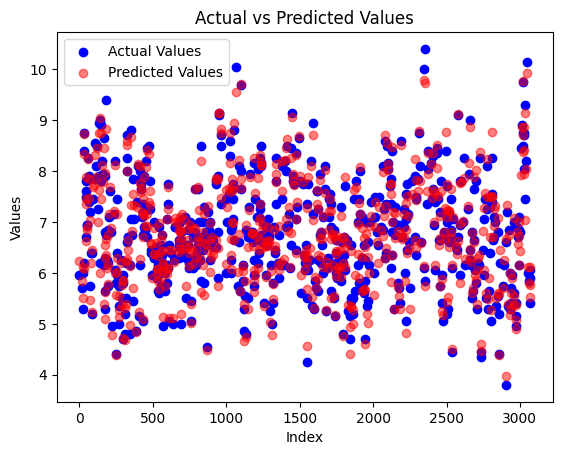

In [19]:
# Scatter plot for actual values
plt.scatter(y_test.index, y_test, color='blue', label='Actual Values')

# Scatter plot for predicted values
plt.scatter(y_test.index, y_pred, color='red', alpha=0.5, label='Predicted Values')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

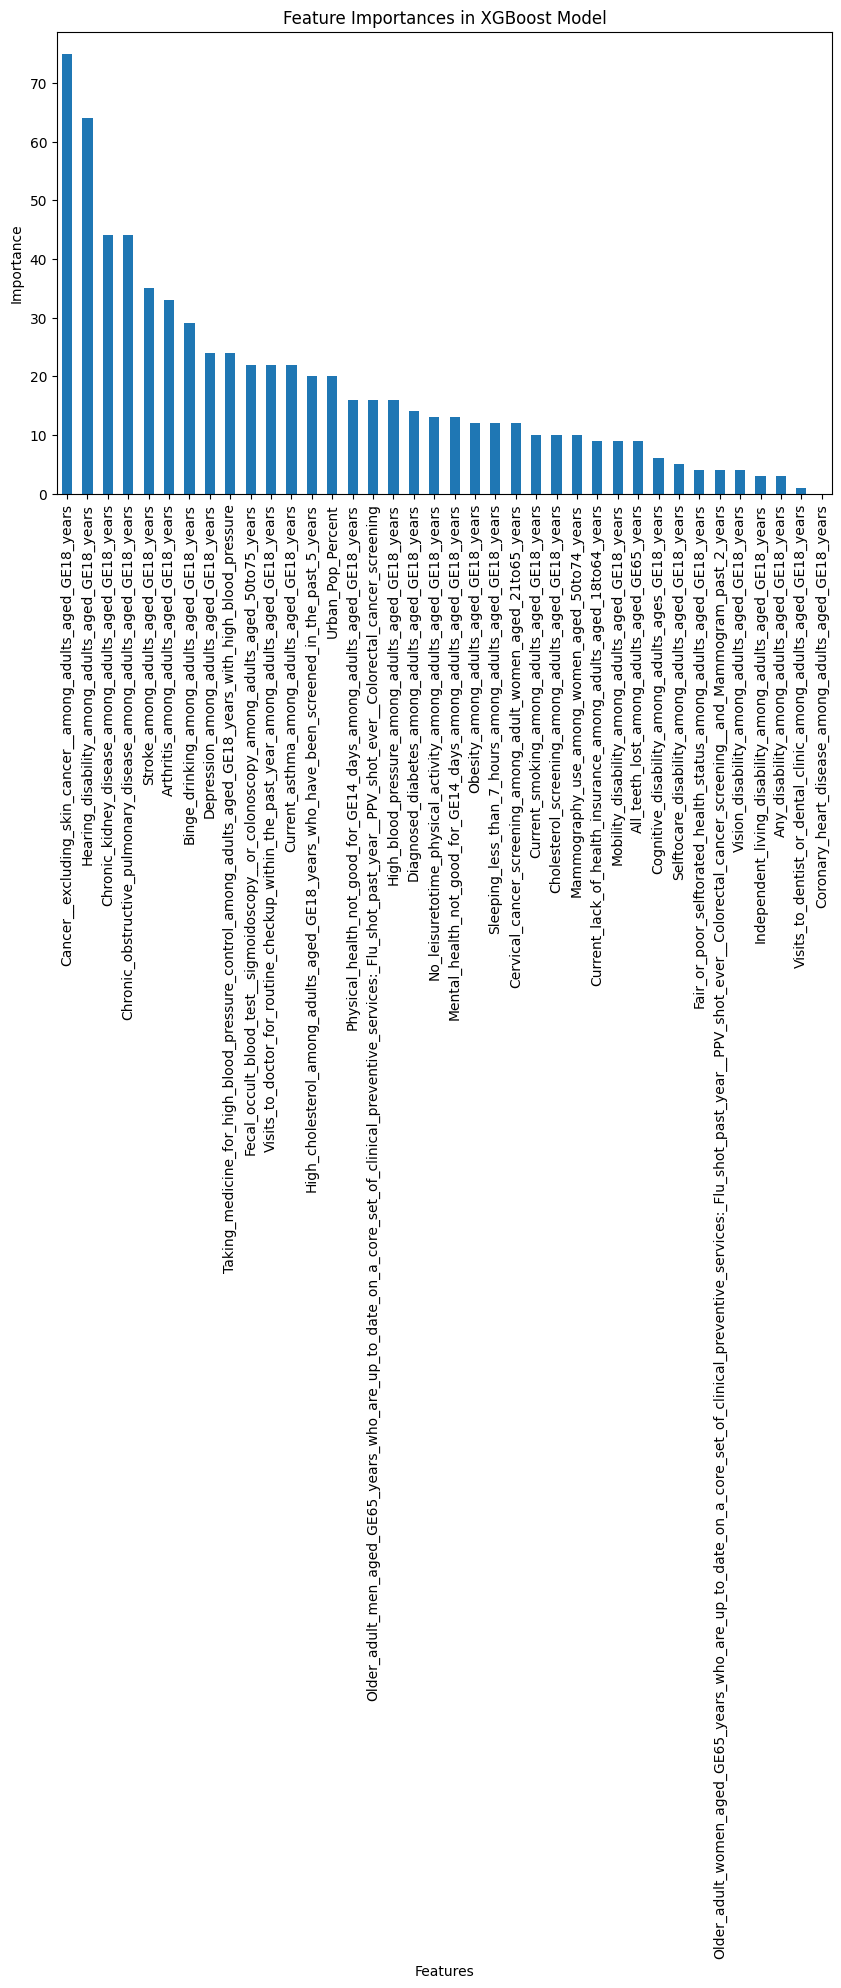

In [20]:
importance_dict = xgb_model.get_score(importance_type='weight')
importances = [importance_dict.get(f, 0.) for f in cdc_xgb.columns]

# Create a series for visualization
importance_series = pd.Series(importances, index=cdc_xgb.columns)

# Sort the feature importances
sorted_importances = importance_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10,6))
sorted_importances.plot(kind='bar')
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### Cross Validation for XGBoost:

In [22]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# Assuming 'X' is your feature set and 'y' is your target variable
# Make sure to import your data and preprocess it as needed

# Initialize XGBoost Regressor
xgb_model_CV = XGBRegressor(random_state=42)

# Perform 10-fold cross-validation
scores = cross_val_score(xgb_model_CV, cdc_xgb_drop, cdc_xgb['Coronary_heart_disease_among_adults_aged_GE18_years'], cv=10, scoring='neg_mean_squared_error')

# Convert the scores to positive values (since 'neg_mean_squared_error' returns negative values)
mse_scores = -scores

# Calculate RMSE for each fold
rmse_scores = np.sqrt(mse_scores)

# Output the results
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard Deviation of RMSE:", rmse_scores.std())


RMSE scores for each fold: [0.29574409 0.19965629 0.24281233 0.41545667 0.19165233 0.1759724
 0.29581932 0.22390832 0.20650375 0.39618015]
Mean RMSE: 0.26437056561443206
Standard Deviation of RMSE: 0.08056967902544164


Perform K-fold cross validation:

In [63]:
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
X = cdc_xgb_drop
y = cdc_xgb['Coronary_heart_disease_among_adults_aged_GE18_years']
# Assuming 'X' and 'y' are your features and target data
kf = KFold(n_splits=10, shuffle=True, random_state=42)
feature_importances = []
scores_r2_cv = []
rmse_scores = []
mean_ab_err = []


# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Convert the data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    #model = XGBRegressor(random_state=42)
    #model.fit(X_train, y_train)
    
    
    # Train the XGBoost model
    xgb_cv_model = xgb.train(params, dtrain, num_boost_round=100)

    # Make predictions on the test set
    y_pred = xgb_cv_model.predict(dtest)

    #
    importance_dict = xgb_cv_model.get_score(importance_type='weight')
    importances = [importance_dict.get(f, 0.) for f in cdc_xgb.columns]

    # Create a series for visualization
    importance_series = pd.Series(importances, index=cdc_xgb.columns)

    # Sort the feature importances
    sorted_importances = importance_series.sort_values(ascending=False)
    
    # Append the feature importances to the list
    feature_importances.append(sorted_importances)

    # Calculate the root mean squared error
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    scores_r2_cv.append(r2_score(y_test, y_pred))

    mean_ab_err.append(mean_absolute_error(y_test, y_pred))

In [64]:
# calculate the average R2:
print("R2 scores for each fold:", scores_r2_cv)

print("Mean R2:", np.mean(scores_r2_cv))

# calculate the average RMSE:
print("RMSE scores for each fold:", rmse_scores)

print("Mean RMSE:", np.mean(rmse_scores))

# calculate the average MAE:
print("Mean Absolute Error scores for each fold:", mean_ab_err)

print("Mean Absolute Error:", np.mean(mean_ab_err))

import statistics
print("Mean RMSE std:", statistics.stdev(rmse_scores))

R2 scores for each fold: [0.9780407476264555, 0.9745205896102334, 0.9758552223595593, 0.9763074947432784, 0.970765492594518, 0.9745754426480596, 0.9728790450380593, 0.9742771453171378, 0.9790176586932047, 0.9734600296156002]
Mean R2: 0.9749698868246105
RMSE scores for each fold: [0.15932530860323835, 0.1695055630189253, 0.17067991722832523, 0.16695343986980693, 0.1870707750899519, 0.1920497572306495, 0.17242861445221072, 0.15916262739694484, 0.17493873960631018, 0.16613146242401017]
Mean RMSE: 0.1718246204920373
Mean Absolute Error scores for each fold: [0.12445867557030216, 0.12918173616582695, 0.12177896623487595, 0.130830828245584, 0.14334247623171129, 0.14477197535626304, 0.13389895529234444, 0.12693743317445638, 0.13205607380074863, 0.12874800405595513]
Mean Absolute Error: 0.1316005124128068
Mean RMSE std: 0.010702811790895592


In [60]:
import statistics
print("Mean RMSE std:", statistics.stdev(rmse_scores))


Mean RMSE std: 0.010702811790895592


Plot importance:

In [35]:
feature_importances[0]

Cancer__excluding_skin_cancer__among_adults_aged_GE18_years                                                                                                                                       70.0
Hearing_disability_among_adults_aged_GE18_years                                                                                                                                                   65.0
Chronic_kidney_disease_among_adults_aged_GE18_years                                                                                                                                               53.0
Chronic_obstructive_pulmonary_disease_among_adults_aged_GE18_years                                                                                                                                50.0
Stroke_among_adults_aged_GE18_years                                                                                                                                                               37.0
Binge

In [47]:
# Concatenate all DataFrames in the list
concatenated_df = pd.concat(feature_importances)

In [53]:
concatenated_df.shape

(380,)

In [50]:
# Calculate the mean across rows for each column
average_df = concatenated_df.mean()

# If you want to keep the DataFrame format
average_df = concatenated_df.mean()

In [51]:
average_df

18.073684210526316

In [36]:
# Average feature importances across all folds
avg_feature_importances = np.mean(feature_importances, axis=0)

In [41]:
avg_feature_importances

array([74.7, 64.6, 49.7, 45.5, 36.9, 33.8, 30.7, 25.3, 23.3, 21.4, 19.6,
       18.4, 17.5, 16.9, 16.3, 15.6, 15.2, 14.6, 14.3, 13.6, 12.9, 12. ,
       11.4, 11. , 10.4,  9.9,  9.2,  8.1,  7.2,  6. ,  5.2,  4.3,  3.7,
        2.6,  2.3,  1.7,  1. ,  0. ])

In [ ]:
feature_importances[9]

In [76]:
import matplotlib.pyplot as plt
import pandas as pd


# Assuming 'X' is your features DataFrame and has column names
#feature_names = cdc_xgb.columns

# Create a Series for the averaged feature importances
#importances = pd.Series(avg_feature_importances, index=feature_names)

# Sort the feature importances for better visualization
#sorted_importances = importances.sort_values(ascending=False)
for i in range(0,10):
    #print(i)
    plt.figure(figsize=(10,26))
    feature_importances[i].plot(kind='bar')
    plt.title('Average Feature Importances from Cross-Validation Folds')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    #plt.show()
    filename = r'/mnt/d/OneDrive - University College London/T1/CASA0007/0. Research Project/outputfigures/feature_importance'+str(i)+'.png'
    plt.savefig(filename)
    plt.close()

In [ ]:

# Assuming 'X' is your features DataFrame and has column names
feature_names = cdc_xgb.columns

# Create a Series for the averaged feature importances
importances = pd.Series(avg_feature_importances, index=feature_names)

# Sort the feature importances for better visualization
sorted_importances = importances.sort_values(ascending=False)
